In [1]:
using QuantumToolbox
using Optim # used to find the points where two eigenvalues cross
using PythonCall

BLAS.set_num_threads(1)

geomspace(start, stop, n) = exp10.(range(log10(start), stop = log10(stop), length = n))

plt = pyimport("matplotlib.pyplot")
plt.rc("text", usetex = true)
plt.rc("text.latex", preamble = raw"\usepackage{amsmath} \usepackage{physics}")
plt.rc("axes", labelpad = 2)
plt.rc("legend", frameon = false)
plt.rc("font", size = 14)
plt.rc("axes", labelsize = 14)    # fontsize of the x and y labels
plt.rc("xtick", labelsize = 14)    # fontsize of the tick labels
plt.rc("ytick", labelsize = 14)    # fontsize of the tick labels
plt.rc("legend", fontsize = 13)

Python: None

## Raman scattering

In [2]:
Nc = 35

a = kron(destroy(Nc), eye(2), eye(2))

σx = kron(eye(Nc), sigmax(), eye(2))
σy = kron(eye(Nc), sigmay(), eye(2))
σz = kron(eye(Nc), sigmaz(), eye(2))

σx_s = kron(eye(Nc), eye(2), sigmax())
σy_s = kron(eye(Nc), eye(2), sigmay())
σz_s = kron(eye(Nc), eye(2), sigmaz())

σp(θ) = cos(θ) * σx + sin(θ) * σz

H_D_sensor(ωc, ωeg, ωs, η, ηs, θ) = ωc * a'*a + ωeg/2 * σz + ωs/2 * σz_s - 1im*η*ωc*(a-a')*σp(θ) - ηs*ωc*( 1im*(a-a') - 2*η*σp(θ) ) * σx_s

function get_liouvillian_sensor(ωs, θ, η, T)
    H_op = H_D_sensor(ωc, ωeg, ωs, η, ηs, θ)
    fields = [sqrt(κc)*( 1im*(a-a') - 2*η*σp(θ) ), sqrt(κa)*σp(θ), sqrt(κs/ωs)*σx_s]
    T_list = [T, T, 0]

    liouvillian_generalized(H_op, fields, T_list, N_trunc=N_trunc, tol=tol, σ_filter=100*(κc))
end

function sensor_population(ωd, ωs, Ad, θ, η, E, U, L)
    Ω = dense_to_sparse(E' .- E, tol)

    X_op = dense_to_sparse( (U' * ( 1im*(a-a') - 2*η*σp(θ) ) * U)[1:N_trunc,1:N_trunc], tol)
    X_op = QuantumObject(X_op)
    Xp = triu(X_op, 1)

    Σ_s = dense_to_sparse( (Ω ./ ωs) .* (U' * σx_s * U)[1:N_trunc,1:N_trunc], tol)
    Σ_s = QuantumObject(Σ_s)
    Σp_s = triu(Σ_s, 1)

    H_t = Ad/2 * X_op

    c_ops = QuantumObject{typeof(L.data), OperatorQuantumObject}[]
    ρss = steadystate_floquet(L, c_ops, H_t, H_t, ωd, n_max=4, lf_solver=LiouvillianDirectSolver(tol=tol^2))
    expect(Σp_s' * Σp_s, ρss)
end

sensor_population (generic function with 1 method)

In [3]:
ωc = 1
ωeg = 1
η = 0.3
θ = π/6
ηs = 1e-5
Ad = 5e-3
κc = 1e-3
κa = 1e-3
κs = 1e-3
T = 0.0
tol = 1e-15
N_trunc = 10

ωd = 1.1

ωs_list = range(1e-4, 1.3, 500)

res_spec = similar(ωs_list)

# sensor_population(ωc, ωs, Ad, θ, η, T)

pr = ProgressBar(length(ωs_list))
Threads.@threads for i in eachindex(ωs_list)
    # res_spec[i] = sensor_population(ωd, ωs_list[i], Ad, θ, η, T)
    # next!(pr)
    E, U, L = get_liouvillian_sensor(ωs_list[i], θ, η, T)
    res_spec[i] = sensor_population(ωd, ωs_list[i], Ad, θ, η, E, U, L)
    next!(pr)
end
# @. res_spec = abs(res_spec);

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)


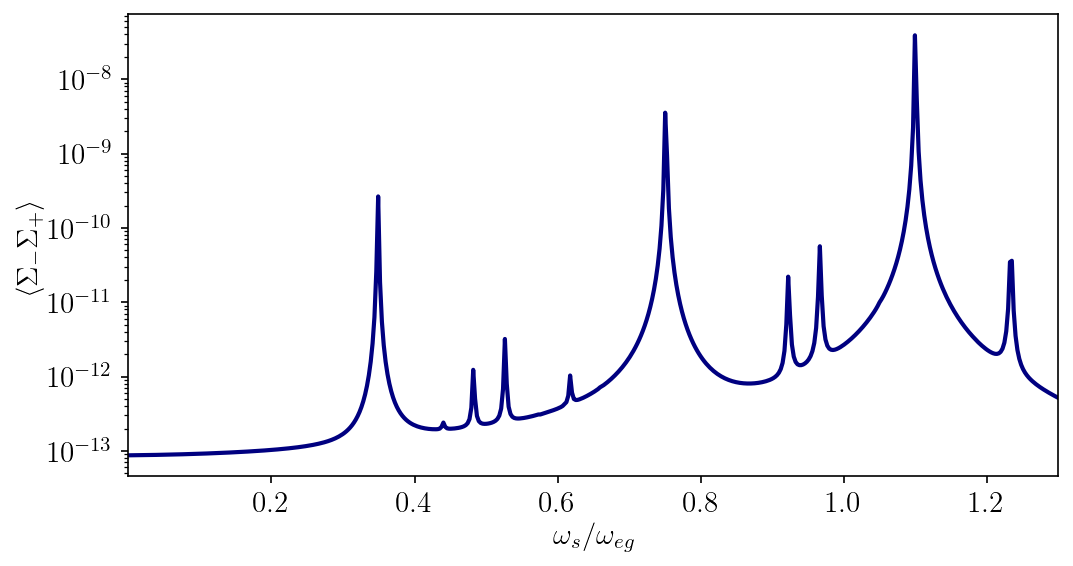

In [4]:
fig, ax = plt.subplots(dpi = 150, figsize = (8, 4))

ax.plot(ωs_list, res_spec, lw=2, color="navy")
ax.set_xlabel(raw"$\omega_s / \omega_{eg}$")
ax.set_ylabel(raw"$\langle \Sigma_- \Sigma_+ \rangle$")
ax.set_xlim(ωs_list[1], ωs_list[end])
# ax.set_ylim(1e-14, 1e-6)
ax.set_yscale("log")

display(fig)

### 2d Plot

In [5]:
# stderr_file = open("stderr.txt", "w+")
# redirect_stderr(stderr_file)

In [5]:
ωc = 1
ωeg = 1
η = 0.3
θ = π/6
ηs = 1e-5
Ad = 5e-3
κc = 1e-3
κa = 1e-3
κs = 1e-3
tol = 1e-15
N_trunc = 15

T1 = 0
T2 = 0.15

ωs_list = range(1e-6, 2.5, 1500)
ωd_list = range(1e-6, 3, 1500)

res_spec_T1 = similar(ωs_list, length(ωd_list), length(ωs_list))
res_spec_T2 = similar(ωs_list, length(ωd_list), length(ωs_list))

pr = ProgressBar(length(ωs_list))
Threads.@threads for i in eachindex(ωs_list)
    E1, U1, L1 = get_liouvillian_sensor(ωs_list[i], θ, η, T1)
    E2, U2, L2 = get_liouvillian_sensor(ωs_list[i], θ, η, T2)
    for j in eachindex(ωd_list)
        res_spec_T1[j, i] = sensor_population(ωd_list[j], ωs_list[i], Ad, θ, η, E1, U1, L1)
        res_spec_T2[j, i] = sensor_population(ωd_list[j], ωs_list[i], Ad, θ, η, E2, U2, L2)
    end
    next!(pr)
end
# @. res_spec = abs(res_spec);

Progress: [==============================] 100.0% --- Elapsed Time: 0h 01m 28s (ETA: 0h 00m 00s)


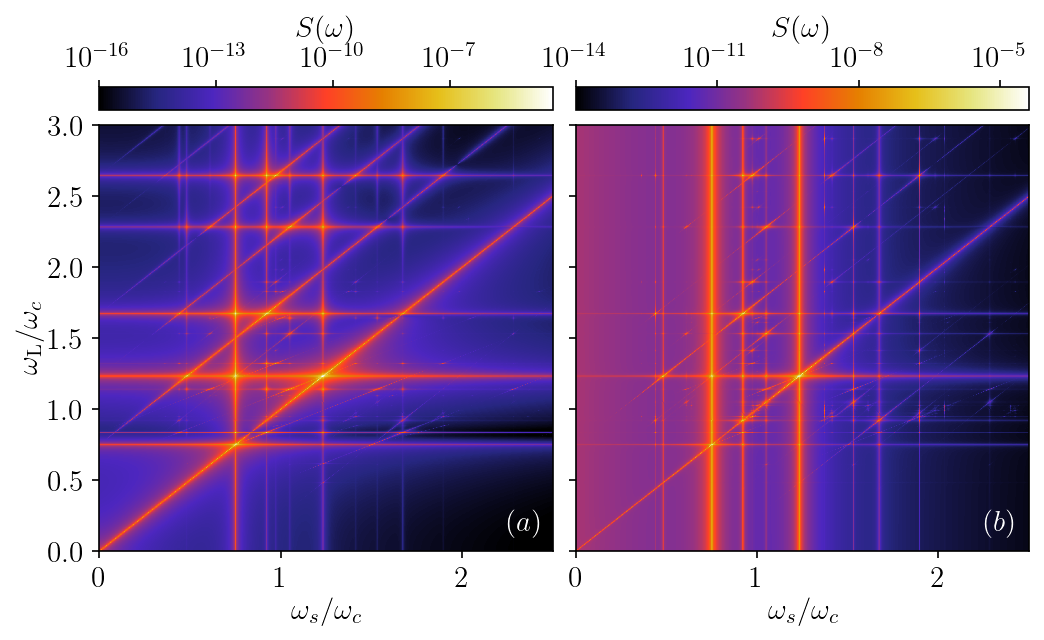

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=true, dpi = 150, figsize = (8, 4.5), gridspec_kw=Dict("hspace"=>0.05, "wspace"=>0.05))

# log norm
vmin1 = 1e-16
vmax1 = maximum(res_spec_T1)
my_norm1 = matplotlib.colors.LogNorm(vmin=vmin1, vmax=vmax1)
vmin2 = 1e-14
vmax2 = maximum(res_spec_T2)
my_norm2 = matplotlib.colors.LogNorm(vmin=vmin2, vmax=vmax2)

ax = axs[1]
img1 = ax.pcolormesh(ωs_list, ωd_list, res_spec_T1, shading="auto", cmap="CMRmap", rasterized=true, norm=my_norm1)
ax.set_xlabel(raw"$\omega_s / \omega_c$")
ax.set_ylabel(raw"$\omega_{\textrm{L}} / \omega_c$")
ax.text(0.9, 0.05, raw"$(a)$", transform=ax.transAxes, color = "white")

ax = axs[2]
img2 = ax.pcolormesh(ωs_list, ωd_list, res_spec_T2, shading="auto", cmap="CMRmap", rasterized=true, norm=my_norm2)
ax.set_xlabel(raw"$\omega_s / \omega_c$")
ax.text(0.9, 0.05, raw"$(b)$", transform=ax.transAxes, color = "white")

colbar1 = fig.colorbar(img1, ax=axs[1], orientation = "horizontal", location="top", pad=0.03)
colbar1.set_label(raw"$S(\omega)$", labelpad=5)

colbar2 = fig.colorbar(img2, ax=axs[2], orientation = "horizontal", location="top", pad=0.03)
colbar2.set_label(raw"$S(\omega)$", labelpad=5)

root_dir = "/home/alberto/"
# # root_dir = "/mnt/c/Users/alber/"
# plt.savefig(root_dir * "OneDrive/GitHub/Latex-Projects/phd-thesis/figures/raman_2d_spectrum.pdf", dpi=300, bbox_inches="tight")

### Possible transitions

In [6]:
a2 = kron(destroy(Nc), eye(2))

σx2 = kron(eye(Nc), sigmax())
σy2 = kron(eye(Nc), sigmay())
σz2 = kron(eye(Nc), sigmaz())

σp2(θ) = cos(θ) * σx2 + sin(θ) * σz2

H_D_sensor_Rabi(ωc, ωeg, η, θ) = ωc * a2'*a2 + ωeg/2 * σz2 - 1im*η*ωc*(a2-a2')*σp2(θ)

function freq_transitions(η, θ)
    H_op = H_D_sensor_Rabi(ωc, ωeg, η, θ)

    E = eigsolve(H_op.data, k=6, sigma=-2).vals
    E = real.(E .- E[1])

    return E
end

freq_transitions (generic function with 1 method)

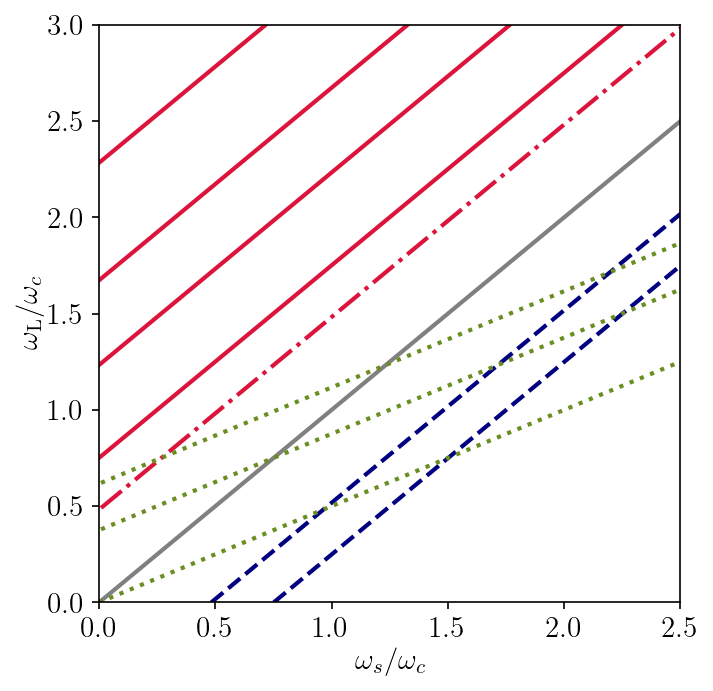

In [7]:
ωc = 1
ωeg = 1
η = 0.3
θ = π/6

ωl_list = range(0, 3, 100)

ω_j0 = freq_transitions(η, θ)
ω_kj = ω_j0' .- ω_j0

fig, ax = plt.subplots(dpi = 150, figsize = (5, 5))

for i in 2:5
    ax.plot(ωl_list .- ω_kj[1,i], ωl_list, lw=2, color="crimson")
end
ax.plot(ωl_list .- ω_kj[2,3], ωl_list, lw=2, color="crimson", ls="-.")

ax.plot(ωl_list, ωl_list, lw=2, color="grey")

ax.plot(ωl_list .- ω_kj[2,1], ωl_list, lw=2, color="navy", ls="--")
ax.plot(ωl_list .- ω_kj[3,2], ωl_list, lw=2, color="navy", ls="--")

ax.plot(2*ωl_list .- ω_kj[1,1], ωl_list, lw=2, color="olivedrab", ls=":")
ax.plot(2*ωl_list .- ω_kj[1,2], ωl_list, lw=2, color="olivedrab", ls=":")
ax.plot(2*ωl_list .- ω_kj[1,3], ωl_list, lw=2, color="olivedrab", ls=":")

ax.set_xlabel(raw"$\omega_s / \omega_c$")
ax.set_ylabel(raw"$\omega_{\textrm{L}} / \omega_c$")
ax.set_xlim(0, 2.5)
ax.set_ylim(ωl_list[1], ωl_list[end])

display(fig)

### Perturbation Theory

In [8]:
function M_fi(ω, X, ωd, f, i)
    res = zero(X[1,1])
    for j in 1:size(X,1)
        res += X[j,f] * X[i,j] / ( ω[i,j] - ωd ) + X[j,f] * X[i,j] / ( ω[i,j] + ωd - ω[i,f] )
    end
    res
end

function get_liouvillian2(θ, η, T)
    H_op = H_D_sensor_Rabi(ωc, ωeg, η, θ)
    fields = [sqrt(κc)*( 1im*(a2-a2') - 2*η*σp2(θ) ), sqrt(κa)*σp2(θ)]
    T_list = [T, T]

    E, U, L = liouvillian_generalized(H_op, fields, T_list, N_trunc=N_trunc, tol=tol, σ_filter=100*(κc))
end

function raman_peak_pert_th(η, θ, ωd, T, f, i)
    E, U, L = get_liouvillian2(θ, η, T)

    ω_kj = E' .- E

    X_op = dense_to_sparse( (U' * ( 1im*(a2-a2') - 2*η*σp2(θ) ) * U)[1:N_trunc,1:N_trunc], tol)
    X_op = QuantumObject(X_op)
    Xp = triu(X_op, 1)

    H_t = Ad/2 * X_op #(Xp + Xp')

    c_ops = QuantumObject{typeof(L.data), OperatorQuantumObject}[]
    ρss = steadystate_floquet(L, c_ops, H_t, H_t, ωd, n_max=4, lf_solver=LiouvillianDirectSolver(tol=tol^2))

    return abs2(M_fi(ω_kj, X_op, ωd, f, i)) * ρss[i,i] * (1 - ρss[f,f])
end

function raman_peak_numerical(η, θ, ωd, T, f, i, n_ωs=50, σ=2)
    ω_j0 = eigvals(H_D_sensor_Rabi(ωc, ωeg, η, θ))[1:N_trunc]
    ω_kj = ω_j0' .- ω_j0
    ωs_list = range(ωd - ω_kj[i,f] - σ*κc, ωd - ω_kj[i,f] + σ*κc, n_ωs)

    res_spectrum = similar(ωs_list)
    for i in eachindex(ωs_list)
        E, U, L = get_liouvillian_sensor(ωs_list[i], θ, η, T)
        res_spectrum[i] = sensor_population(ωd, ωs_list[i], Ad, θ, η, E, U, L)
    end
    res_spectrum
end

raman_peak_numerical (generic function with 3 methods)

In [9]:
ωc = 1
ωeg = 1
η = 0.3
θ = π/6
ηs = 1e-5
Ad = 5e-3
κc = 1e-3
κa = 1e-3
κs = 1e-3
T = 0
N_trunc = 10
tol=1e-15

ωd = 1.1

# Figure 1
final_state = 2
initial_state = 1
η_list = geomspace(0.01, 0.3, 500)
res_pert_th = similar(η_list)
res_num = similar(η_list)
pr = ProgressBar(length(η_list))
Threads.@threads for i in eachindex(η_list)
    res_pert_th[i] = raman_peak_pert_th(η_list[i], θ, ωd, T, final_state, initial_state)
    res_num[i] = maximum(raman_peak_numerical(η_list[i], θ, ωd, T, final_state, initial_state))
    next!(pr)
end

# Figure 2
final_state = 2
initial_state = 1
η1, η2, η3 = 0.01, 0.05, 0.1
n_ωs = 100
stokes_peak_10 = zeros(Float64, n_ωs, 3)
stokes_peak_10[:,1] = raman_peak_numerical(η1, θ, ωd, T, final_state, initial_state, n_ωs, 3)
stokes_peak_10[:,2] = raman_peak_numerical(η2, θ, ωd, T, final_state, initial_state, n_ωs, 3)
stokes_peak_10[:,3] = raman_peak_numerical(η3, θ, ωd, T, final_state, initial_state, n_ωs, 3)

# Figure 3
ωd1 = 1.1
ωd2 = 2.1
final_state1 = 2
final_state2 = 4
initial_state = 1
θ_list = range(0, π, 500)
res_theta_pert_th1 = similar(θ_list)
res_theta_pert_th2 = similar(θ_list)
res_theta_num1 = similar(θ_list)
res_theta_num2 = similar(θ_list)
pr = ProgressBar(length(θ_list))
Threads.@threads for i in eachindex(θ_list)
    res_theta_pert_th1[i] = raman_peak_pert_th(η, θ_list[i], ωd1, T, final_state1, initial_state)
    res_theta_pert_th2[i] = raman_peak_pert_th(η, θ_list[i], ωd2, T, final_state2, initial_state)
    res_theta_num1[i] = maximum(raman_peak_numerical(η, θ_list[i], ωd1, T, final_state1, initial_state))
    res_theta_num2[i] = maximum(raman_peak_numerical(η, θ_list[i], ωd2, T, final_state2, initial_state))
    next!(pr)
end

# Figure 4
N_trunc = 15
tol=1e-40
T_list = range(0, 0.25, 300)
final_state = 2
initial_state = 1
res_temp_stokes_pert_th = similar(T_list)
res_temp_antistokes_pert_th = similar(T_list)
res_temp_stokes_num = similar(T_list)
res_temp_antistokes_num = similar(T_list)
pr = ProgressBar(length(T_list))
Threads.@threads for i in eachindex(T_list)
    res_temp_stokes_pert_th[i] = raman_peak_pert_th(η, θ, ωd, T_list[i], final_state, initial_state)
    res_temp_antistokes_pert_th[i] = raman_peak_pert_th(η, θ, ωd, T_list[i], initial_state, final_state)
    res_temp_stokes_num[i] = maximum(raman_peak_numerical(η, θ, ωd, T_list[i], final_state, initial_state))
    res_temp_antistokes_num[i] = maximum(raman_peak_numerical(η, θ, ωd, T_list[i], initial_state, final_state))
    next!(pr)
end

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 28s (ETA: 0h 00m 00s)                                                                                                 
Progress: [==============================] 100.0% --- Elapsed Time: 0h 01m 00s (ETA: 0h 00m 00s)
Progress: [==============================] 100.0% --- Elapsed Time: 0h 02m 45s (ETA: 0h 00m 00s)


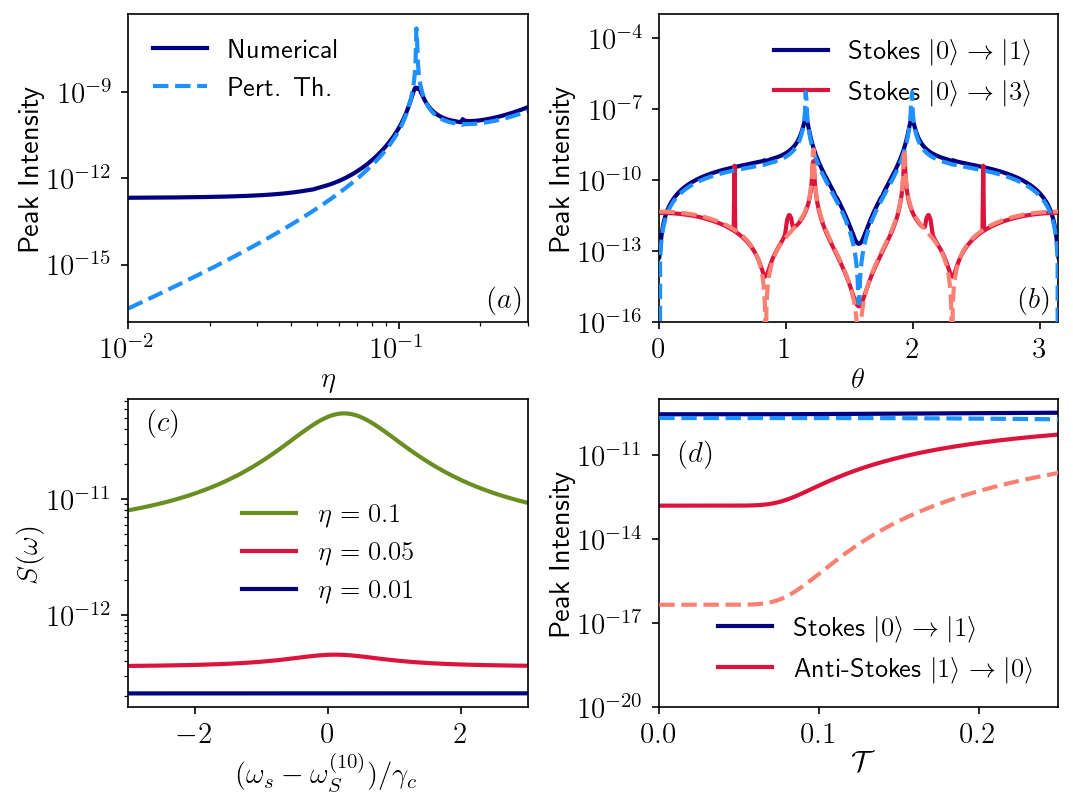

"/home/alberto/"

In [11]:
fig, axs = plt.subplots(2, 2, dpi = 150, figsize = (8, 6), gridspec_kw=Dict("hspace"=>0.25, "wspace"=>0.33))

factor = 2 * (Ad/2)^2 * (ηs * ωc)^2 / κs^2
# factor = (res_num[end] / res_pert_th[end])

ax = axs[0,0]
ax.plot(η_list, res_num, lw=2, color="navy", label="Numerical")
ax.plot(η_list, res_pert_th .* factor, lw=2, color="dodgerblue", ls="--", label="Pert. Th.")
ax.set_xlabel(raw"$\eta$")
ax.set_ylabel(raw"Peak Intensity")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(η_list[1], η_list[end])
ax.text(0.9, 0.05, raw"$(a)$", transform=ax.transAxes, color = "black")
ax.legend()

ax = axs[1,0]
ω_list = range(-3, 3, n_ωs)
ax.plot(ω_list, stokes_peak_10[:,3], lw=2, color="olivedrab", label=raw"$\eta = 0.1$")
ax.plot(ω_list, stokes_peak_10[:,2], lw=2, color="crimson", label=raw"$\eta = 0.05$")
ax.plot(ω_list, stokes_peak_10[:,1], lw=2, color="navy", label=raw"$\eta = 0.01$")
ax.set_xlabel(raw"$(\omega_s - \omega_S^{(10)}) / \gamma_c$")
ax.set_ylabel(raw"$S(\omega)$")
# ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(ω_list[1], ω_list[end])
ax.text(0.05, 0.9, raw"$(c)$", transform=ax.transAxes, color = "black")
ax.legend()

ax = axs[0,1]
ax.plot(θ_list, res_theta_num1, lw=2, color="navy", label=raw"Stokes $\ket{0} \to \ket{1}$")
ax.plot(θ_list, res_theta_pert_th1 .* factor,
        lw=2, color="dodgerblue", ls="--", zorder=10)
ax.plot(θ_list, res_theta_num2, lw=2, color="crimson", label=raw"Stokes $\ket{0} \to \ket{3}$")
ax.plot(θ_list, res_theta_pert_th2 .* factor,
        lw=2, color="salmon", ls="--", zorder=11)
ax.set_xlabel(raw"$\theta$")
ax.set_ylabel(raw"Peak Intensity")
ax.set_ylim(1e-16, 1e-3)
ax.set_yscale("log")
ax.set_xlim(θ_list[1], θ_list[end])
ax.text(0.9, 0.05, raw"$(b)$", transform=ax.transAxes, color = "black")
ax.legend()

ax = axs[1,1]
ax.plot(T_list, res_temp_stokes_num, lw=2, color="navy", label=raw"Stokes $\ket{0} \to \ket{1}$")
ax.plot(T_list, res_temp_stokes_pert_th .* factor,
        lw=2, color="dodgerblue", ls="--", zorder=10)
ax.plot(T_list, res_temp_antistokes_num, lw=2, color="crimson", label=raw"Anti-Stokes $\ket{1} \to \ket{0}$")
ax.plot(T_list, res_temp_antistokes_pert_th .* factor,
        lw=2, color="salmon", ls="--", zorder=11)
ax.set_xlabel(raw"$\mathcal{T}$")
ax.set_ylabel(raw"Peak Intensity")
ax.set_ylim(1e-20, 1e-9)
ax.set_yscale("log")
ax.set_xlim(T_list[1], T_list[end])
ax.text(0.05, 0.8, raw"$(d)$", transform=ax.transAxes, color = "black")
ax.legend()

display(fig)

root_dir = "/home/alberto/"
# root_dir = "/mnt/c/Users/alber/"
# plt.savefig(root_dir * "OneDrive/GitHub/Latex-Projects/phd-thesis/figures/raman_pert_th.pdf", dpi=300, bbox_inches="tight")

### Fisher information

In [12]:
ωc = 1
ωeg = 1
θ = π/6
ηs = 1e-5
Ad = 5e-3
κc = 1e-3
κa = 1e-3
κs = 1e-3
T = 0
N_trunc = 10
tol=1e-15

ωd = 1.1

δη = 0.0005
η1 = 0.3
η2 = η1 + δη

σ_spec = 4
n_ωs = 500
ω_j0 = eigvals(H_D_sensor_Rabi(ωc, ωeg, η1, θ))
ω_j0 = ω_j0 .- ω_j0[1]
ωs_list_stokes = range(ωd - ω_j0[2] - σ_spec*κc, ωd - ω_j0[2] + σ_spec*κc, n_ωs)
ωs_list_direct = range(ω_j0[2] - σ_spec*κs, ω_j0[2] + σ_spec*κs, n_ωs)

res_spec_stokes1 = similar(ωs_list_stokes)
res_spec_direct1 = similar(ωs_list_direct)
res_spec_stokes2 = similar(ωs_list_stokes)
res_spec_direct2 = similar(ωs_list_direct)

pr = ProgressBar(length(ωs_list_stokes))
Threads.@threads for i in eachindex(ωs_list_stokes)
    E1, U1, L1 = get_liouvillian_sensor(ωs_list_stokes[i], θ, η1, T)
    E2, U2, L2 = get_liouvillian_sensor(ωs_list_stokes[i], θ, η2, T)
    res_spec_stokes1[i] = sensor_population(ωd, ωs_list_stokes[i], Ad, θ, η1, E1, U1, L1)
    res_spec_stokes2[i] = sensor_population(ωd, ωs_list_stokes[i], Ad, θ, η2, E2, U2, L2)

    E1, U1, L1 = get_liouvillian_sensor(ωs_list_direct[i], θ, η1, T)
    E2, U2, L2 = get_liouvillian_sensor(ωs_list_direct[i], θ, η2, T)
    res_spec_direct1[i] = sensor_population(ωd, ωs_list_direct[i], Ad, θ, η1, E1, U1, L1)
    res_spec_direct2[i] = sensor_population(ωd, ωs_list_direct[i], Ad, θ, η2, E2, U2, L2)
    next!(pr)
end

fisher_stokes = mapreduce(i -> ((res_spec_stokes2[i] - res_spec_stokes1[i]) / δη)^2 / res_spec_stokes1[i], +, 1:n_ωs)
fisher_direct = mapreduce(i -> ((res_spec_direct2[i] - res_spec_direct1[i]) / δη)^2 / res_spec_direct1[i], +, 1:n_ωs);

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)


Fisher ratio: 4.21
Peak ratio: 4.17


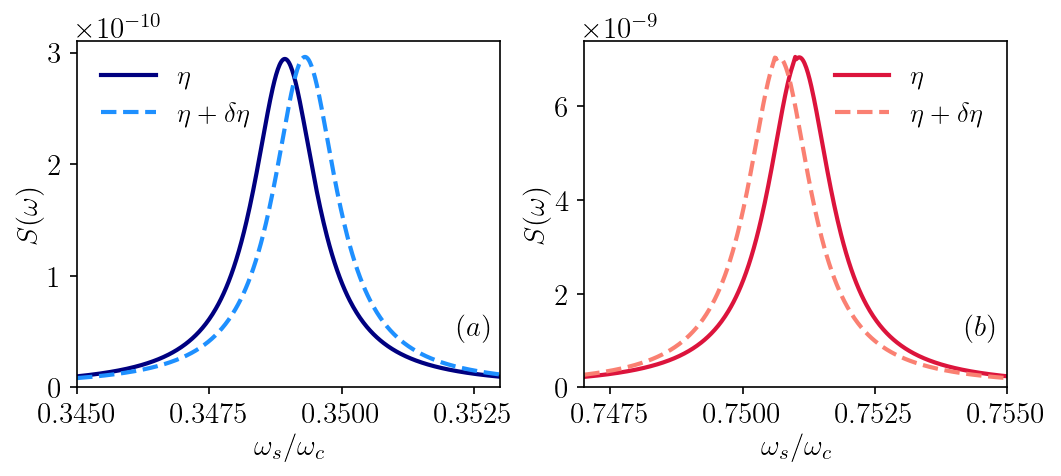

"/home/alberto/"

In [13]:
fig, axs = plt.subplots(1, 2, dpi = 150, figsize = (8, 3), gridspec_kw=Dict("hspace"=>0.35, "wspace"=>0.2))

println("Fisher ratio: ", round(100 * fisher_stokes / fisher_direct, digits=2))
println("Peak ratio: ", round(100 * maximum(res_spec_stokes1) / maximum(res_spec_direct1), digits=2))

ax = axs[0]
ax.plot(ωs_list_stokes, res_spec_stokes1, lw=2, color="navy", label=raw"$\eta$")
ax.plot(ωs_list_stokes, res_spec_stokes2, lw=2, color="dodgerblue", ls="--", label=raw"$\eta + \delta \eta$")
ax.set_xlabel(raw"$\omega_s / \omega_c$")
ax.set_ylabel(raw"$S(\omega)$")
ax.set_xlim(ωs_list_stokes[1], ωs_list_stokes[end])
ax.set_ylim(0, nothing)
# ax.set_yscale("log")
ax.text(0.9, 0.15, raw"$(a)$", transform=ax.transAxes, color = "black")
ax.legend()

ax = axs[1]
ax.plot(ωs_list_direct, res_spec_direct1, lw=2, color="crimson", label=raw"$\eta$")
ax.plot(ωs_list_direct, res_spec_direct2, lw=2, color="salmon", ls="--", label=raw"$\eta + \delta \eta$")
ax.set_xlabel(raw"$\omega_s / \omega_c$")
ax.set_ylabel(raw"$S(\omega)$")
ax.set_xlim(ωs_list_direct[1], ωs_list_direct[end])
ax.set_ylim(0, nothing)
# ax.set_yscale("log")
ax.text(0.9, 0.15, raw"$(b)$", transform=ax.transAxes, color = "black")
ax.legend()

display(fig)

root_dir = "/home/alberto/"
# root_dir = "/mnt/c/Users/alber/"
# plt.savefig(root_dir * "OneDrive/GitHub/Latex-Projects/phd-thesis/figures/raman_fisher_information.pdf", dpi=300, bbox_inches="tight")